# COMP3314 Group 23

This is a kaggle notebook for COMP3314 paper reproduction [Visualizing Data using t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) original kaggle: [dimensionality reduction on the mnist](https://www.kaggle.com/code/youseefmoemen/dimensionality-reduction-on-the-mnist)

HOW TO RUN: press "run all" above (takes a couple minutes), interrupt: 3 dots on top right, "interrupt execution"

# Loading and Spliting **Mnist**

We will load the popular most dataset using  ```fetch_openml``` from sklearn.
The *mnist* consist of **60000**  different image each of them consist of 28 * 28 pixels considering these dimensions we will have in total a **784 features**
We will take **10000** for testing using `train_test_split` from sklearn

In [1]:
%%time
from sklearn.datasets import fetch_openml

CPU times: user 2.55 s, sys: 93.8 ms, total: 2.65 s
Wall time: 992 ms


In [2]:
%%time
import numpy as np
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X - np.min(X)
X = X / np.max(X)
X = X - np.mean(X, axis=0)
print(f"dimensions of X: {X.shape}")

dimensions of X: (70000, 784)
CPU times: user 3.53 s, sys: 466 ms, total: 4 s
Wall time: 4.02 s


In [3]:
%%time
from sklearn.decomposition import PCA
print("pca start")
pca = PCA(n_components=50)
X = pca.fit_transform(X)
print("pca end")
X = X - np.min(X)
X = X / np.max(X)
X = X - np.mean(X, axis=0)
print(f"dimensions of X (after pca): {X.shape}")

pca start
pca end
dimensions of X (after pca): (70000, 50)
CPU times: user 4.99 s, sys: 66.5 ms, total: 5.06 s
Wall time: 774 ms


In [4]:
%%time
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

CPU times: user 97.7 ms, sys: 0 ns, total: 97.7 ms
Wall time: 14.6 ms


In [5]:
%%time
idx = np.random.permutation(60000)[:6000]
X = X[idx]
y = y[idx]

CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 3.33 ms


In [6]:
!pip install numba


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


Cost_early = 4 * KL(P || Q) + 4 * log(4)

What Happens to the Cost:

    The cost increases dramatically during early exaggeration because:

        The first term 4 * KL(P || Q) is 4× larger

        The second term 4 * log(4) adds a constant (~5.55)

    In your output, this explains the pattern:
    text

Iter 0: Cost 18.579063157258744354 (early ex)   ← High cost during exaggeration
...
Early exaggeration ended at iteration 50
Iter 50: Cost 3.258469183553598381              ← Drops dramatically when exaggeration stops

start tsne
Custom t-SNE: 6000 samples -> 2 dimensions
Early exaggeration: 12.0 for 250 iterations
Computing input similarities...
Initializing embedding...
[[-6.07547697e-05 -1.26136415e-05]
 [-6.84606359e-05  9.28714749e-05]
 [-1.84440103e-04 -4.67002424e-05]
 [ 2.29249034e-04  4.88810054e-05]
 [ 7.10266991e-05  1.05553444e-04]
 [ 5.40731003e-06  2.57953416e-05]
 [ 5.88281650e-05  8.85244239e-05]
 [-1.01700702e-04 -1.33693031e-05]
 [-4.38185501e-05  4.93443494e-05]
 [-1.99009120e-05 -1.27498361e-04]]
Starting optimization...
Iter 0: Cost 88.220939387390743036, Grad 0.000085711647248615 (early ex)
Iter 10: Cost 93.545765752845198904, Grad 0.158338258379525892 (early ex)
Iter 20: Cost 94.957478078162353086, Grad 0.148423262205906403 (early ex)
Iter 30: Cost 94.392101414024836004, Grad 0.146258745077278818 (early ex)
Iter 40: Cost 91.993866529715091929, Grad 0.143785176532707032 (early ex)
Iter 50: Cost 90.793437817994785632, Grad 0.141406086809568510 (early ex)
Iter 60: Cost 90.47965064

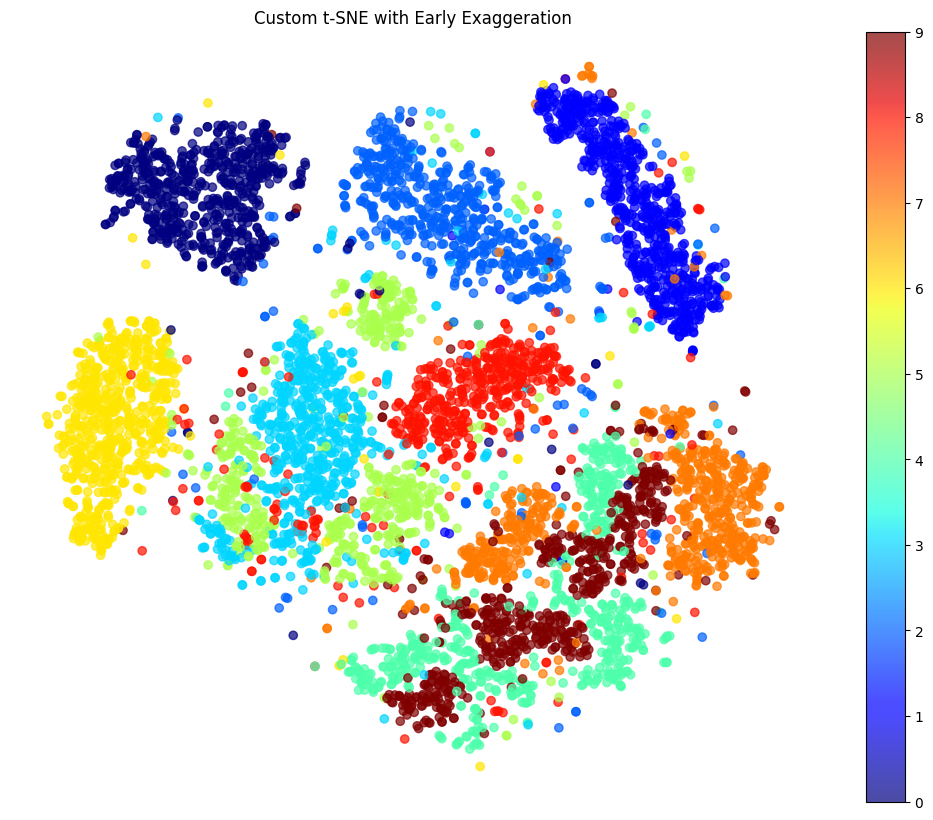

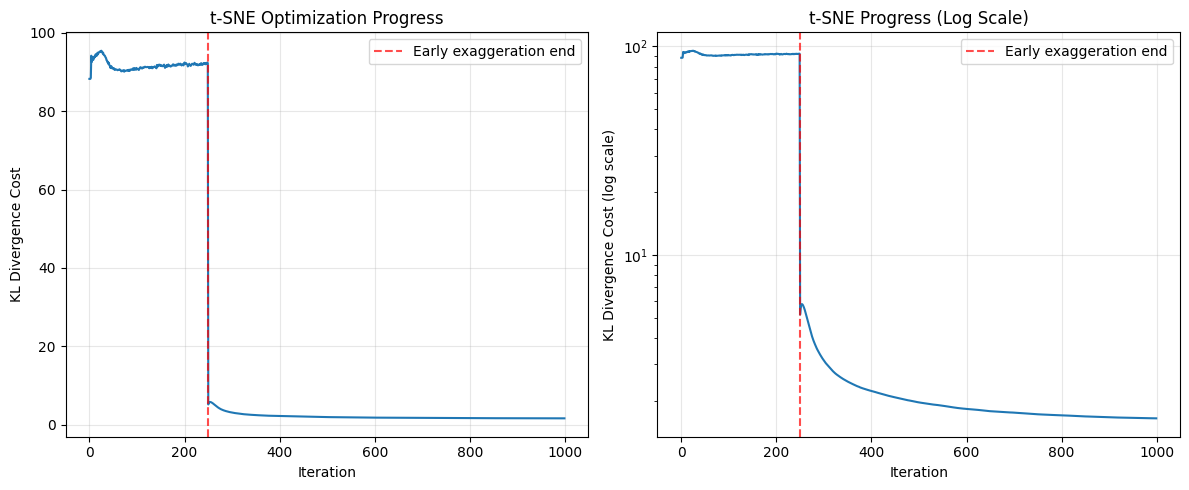


Testing different early exaggeration settings:
CPU times: user 1h 39min 39s, sys: 22min 18s, total: 2h 1min 58s
Wall time: 24min 11s


In [7]:
%%time
#from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import warnings
from numba import jit, prange

@jit(nopython=True, parallel=True)
def compute_entropy_numba(D, beta):
    """
    Numba-compatible entropy computation.
    """
    # Safe exponentiation
    P = np.exp(-D * beta)
    
    # Numerical stability
    P = np.maximum(P, 1e-100)
    sumP = np.sum(P)
    
    # Safe division
    if sumP <= 0:
        sumP = 1e-12
        P = np.ones_like(P) / len(P)
    else:
        P = P / sumP
    
    # Safe entropy calculation
    P_safe = np.maximum(P, 1e-12)
    H = np.log(max(sumP, 1e-12)) + beta * np.sum(D * P)
    
    return H, P

# Alternative version using scipy pdist (if you want to keep scipy's optimized distance)
def compute_pairwise_affinities_hybrid(X, perplexity=40.0, tol=1e-5, max_iter=50):
    """
    Hybrid version: use scipy for distances, Numba for binary search.
    """
    n = X.shape[0]
    
    # Use scipy for efficient distance computation
    D = squareform(pdist(X, 'sqeuclidean'))
    D = np.maximum(D, 1e-12)
    
    # Numba-optimized binary search
    P = _compute_affinities_numba_core(D, perplexity, tol, max_iter)
    
    # Symmetrize and normalize
    np.fill_diagonal(P, 0)
    P = (P + P.T) / 2
    P = P / np.sum(P)
    P = np.maximum(P, 1e-12)
    
    return P

@jit(nopython=True, parallel=True)
def _compute_affinities_numba_core(D, perplexity, tol, max_iter):
    """
    Numba core for affinity computation.
    """
    n = D.shape[0]
    P = np.zeros((n, n))
    log_perplexity = np.log(perplexity)
    
    for i in range(n):
        beta_min = -np.inf
        beta_max = np.inf
        beta = 1.0
        
        # Get non-diagonal distances for this point
        indices = np.zeros(n-1, dtype=np.int64)
        Di = np.zeros(n-1)
        
        count = 0
        for j in range(n):
            if j != i:
                indices[count] = j
                Di[count] = D[i, j]
                count += 1
        
        Di = np.maximum(Di, 1e-12)
        
        H, thisP = compute_entropy_numba(Di, beta)
        Hdiff = H - log_perplexity
        tries = 0
        
        while np.abs(Hdiff) > tol and tries < max_iter:
            if Hdiff > 0:
                beta_min = beta
                if beta_max == np.inf:
                    beta = beta * 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                beta_max = beta
                if beta_min == -np.inf:
                    beta = beta / 2.0
                else:
                    beta = (beta + beta_min) / 2.0
            
            H, thisP = compute_entropy_numba(Di, beta)
            Hdiff = H - log_perplexity
            tries += 1
        
        # Set P row
        for idx, j in enumerate(indices):
            P[i, j] = thisP[idx]
    
    return P

@jit(nopython=True, parallel=True)
def compute_grad_numba(P, Y, shouldprint=False):
    n, dim = Y.shape
    
    # distance computation
    sum_ydata = np.sum(Y ** 2, axis=1)
    YYt = Y @ Y.T
    D_sq = sum_ydata.reshape(-1, 1) + sum_ydata.reshape(1, -1) - 2 * YYt
    
    # Student-t distribution 
    num = 1.0 / (1.0 + D_sq)
    
    np.fill_diagonal(num, 0)
    total_sum = np.sum(num)
    Q = num / total_sum
    #Q = np.maximum(Q, 1e-12)
    
    L = (P - Q) * num
    grad = 4 * (np.diag(np.sum(L, axis=1)) - L) @ Y

    # comment out jit decorator to use below debug print
    # if shouldprint:
    #     print(f"debug: P {P[:5,:5]}, Q {Q[:5,:5]}, L {L[:5,:5]}, Y {Y[:5,:5]}, grad {grad[:5,:5]}")
    
    return grad, Q

@jit(nopython=True, parallel=True)
def safe_kl_divergence(P, Q):
    """
    Compute KL divergence with numerical stability.
    """
    # Ensure no zeros in P and Q for log computation
    P_safe = np.maximum(P, 1e-12)
    Q_safe = np.maximum(Q, 1e-12)
    
    # Avoid log(0) issues
    log_ratio = np.log(P_safe) - np.log(Q_safe)
    
    # Compute KL divergence
    kl = np.sum(P_safe * log_ratio)
    
    return kl

def custom_tsne(X, n_components=2, perplexity=40.0, early_exaggeration=12.0,
                learning_rate=1000.0, max_iter=1000, initial_variance=0.0001, dbd_kappa=0.375, dbd_phi=0.909090,
                random_state=None, verbose=True, verbosefreq=10, momentum=0.5, final_momentum=0.8,
                mom_switch_iter=250, early_exaggeration_iters=250, n_jobs=6):
    """
    Custom t-SNE implementation with proper early exaggeration.
    
    Parameters:
    -----------
    early_exaggeration : float, default=12.0
        Factor to exaggerate P matrix in early iterations
    early_exaggeration_iters : int, default=250
        Number of iterations to apply early exaggeration
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n = X.shape[0]
    
    # Adjust perplexity if too large
    if perplexity >= n:
        perplexity = max(1, n - 1)
        if verbose:
            print(f"Perplexity adjusted to {perplexity}")
    
    if verbose:
        print(f"Custom t-SNE: {n} samples -> {n_components} dimensions")
        print(f"Early exaggeration: {early_exaggeration} for {early_exaggeration_iters} iterations")
        print("Computing input similarities...")
    
    # Step 1: Compute input similarities (high-dimensional affinities)
    P = compute_pairwise_affinities_hybrid(X, perplexity=perplexity)
    
    # Store original P for later
    P_original = P.copy()
    
    # Apply early exaggeration to P
    P_exaggerated = P * early_exaggeration
    
    # Step 2: Initialize solution
    if verbose:
        print("Initializing embedding...")
    
    # Use PCA initialization (better than random)
    # try:
    #     Y = PCA(n_components=n_components).fit_transform(X)
    #     Y = Y / (np.std(Y, axis=0) + 1e-12) * 0.0001  # Safe scaling
    # except:
    Y = np.random.randn(n, n_components) * initial_variance
    print(Y[:10,:10])
    
    # Initialize velocities and gains
    velocities = np.zeros_like(Y)
    gains = np.ones_like(Y)
    
    # Progress tracking
    costs = []
    
    if verbose:
        print("Starting optimization...")
    
    # Step 3: Perform gradient descent
    for iteration in range(max_iter):
        # Apply early exaggeration for the first N iterations
        if iteration < early_exaggeration_iters:
            current_P = P_exaggerated
            exaggeration_active = True
        else:
            current_P = P_original
            exaggeration_active = False
        
        # Compute low-dimensional affinities
        # Q = compute_low_dimensional_affinities_numba(Y)
        
        # Compute gradient (no early exaggeration in gradient - it's already in P)
        # grad = tsne_gradient_numba(current_P, Q, Y)
        
        grad, Q = compute_grad_numba(current_P, Y, verbose and iteration % verbosefreq == 0)
        
        # Compute cost (KL divergence) safely
        cost = safe_kl_divergence(current_P, Q)
        costs.append(cost)
        
        # Update the solution using momentum
        if iteration < mom_switch_iter:
            current_momentum = momentum
        else:
            current_momentum = final_momentum
        
        # Update gains safely
        grad_sign = np.sign(grad)
        vel_sign = np.sign(velocities)
        
        gains = np.where(grad_sign != vel_sign, gains + dbd_kappa, gains * dbd_phi)
        # gains = np.clip(gains, 0.01, 10.0)  # Bound gains
        gains = np.maximum(gains, 0.01)
        
        # Update velocities
        velocities = current_momentum * velocities - learning_rate * gains * grad
        # velocities = current_momentum * velocities - learning_rate * grad
        
        # Update solution
        Y = Y + velocities
        
        # Center the embedding safely
        Y_mean = np.mean(Y, axis=0)
        if np.any(np.isnan(Y_mean)) or np.any(np.isinf(Y_mean)):
            Y_mean = np.zeros(n_components)
        Y = Y - Y_mean
        
        # Check for numerical issues
        if np.any(np.isnan(Y)) or np.any(np.isinf(Y)):
            if verbose:
                print(f"Numerical instability detected at iteration {iteration}")
            # Reset with small random noise
            Y = np.random.randn(n, n_components) * 0.0001
            velocities = np.zeros_like(Y)
        
        # Check convergence
        grad_norm = np.linalg.norm(grad)
        if np.isnan(grad_norm) or np.isinf(grad_norm):
            print("WARNING grad_norm is nan or inf")
            grad_norm = min_grad_norm * 10  # Force continuation
        
        # Progress reporting
        if verbose and iteration % verbosefreq == 0:
            status = " (early ex)" if exaggeration_active else ""
            print(f"Iter {iteration}: Cost {cost:.18f}, Grad {grad_norm:.18f}{status}")
        
        # Stop if gradient is too small
        # if grad_norm < min_grad_norm:
        #     if verbose:
        #         print(f"\nConverged at iteration {iteration}: gradient norm {grad_norm:.6f} < {min_grad_norm}")
        #     break
        
        # Report when early exaggeration ends
        if iteration == early_exaggeration_iters - 1 and verbose:
            print(f"\nEarly exaggeration ended at iteration {iteration + 1}")
    
    if verbose:
        print(f"Final cost: {costs[-1]:.4f}")
        print(f"Total iterations: {iteration + 1}")
    
    return Y, costs

# Usage example:
def plot_tsne_results(X_embedded, y, title="Custom t-SNE"):
    plt.figure(figsize=(13, 10))
    scatter = plt.scatter(X_embedded[:, 0], X_plot_tsne[:, 1], c=[int(i) for i in y], cmap="jet", alpha=0.7)
    plt.colorbar(scatter)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Run custom t-SNE with different early exaggeration settings
try:
    # Test with default early exaggeration
    print("start tsne")
    X_plot_tsne, costs = custom_tsne(
        X, 
        n_components=2,
        random_state=40,
        verbose=True
    )
    
    # Plot results
    plot_tsne_results(X_plot_tsne, y, "Custom t-SNE with Early Exaggeration")
    
    # Plot cost function with early exaggeration region highlighted
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(costs)
    plt.axvline(x=250, color='red', linestyle='--', alpha=0.7, label='Early exaggeration end')
    plt.xlabel('Iteration')
    plt.ylabel('KL Divergence Cost')
    plt.title('t-SNE Optimization Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(costs)
    plt.axvline(x=250, color='red', linestyle='--', alpha=0.7, label='Early exaggeration end')
    plt.xlabel('Iteration')
    plt.ylabel('KL Divergence Cost (log scale)')
    plt.yscale('log')
    plt.title('t-SNE Progress (Log Scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # You can also test with different early exaggeration parameters:
    print("\n" + "="*50)
    print("Testing different early exaggeration settings:")
    '''
    # No early exaggeration
    X_plot_tsne_no_ex, costs_no_ex = custom_tsne(
        X, 
        n_components=2,
        random_state=40,
        verbose=True,
        early_exaggeration=1.0
    )
    
    # Strong early exaggeration
    X_plot_tsne_strong, costs_strong = custom_tsne(
        X, 
        n_components=2,
        random_state=40,
        verbose=True,
        early_exaggeration=12.0
    )
    
    # Compare results
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[1].scatter(X_plot_tsne[:, 0], X_plot_tsne[:, 1], c=[int(i) for i in y], cmap="jet", alpha=0.7)
    axes[1].set_title('Standard Early Exaggeration (4x)')
    axes[1].axis('off')
    
    axes[0].scatter(X_plot_tsne_no_ex[:, 0], X_plot_tsne_no_ex[:, 1], c=[int(i) for i in y], cmap="jet", alpha=0.7)
    axes[0].set_title('No Early Exaggeration (1x)')
    axes[0].axis('off')
    
    axes[2].scatter(X_plot_tsne_strong[:, 0], X_plot_tsne_strong[:, 1], c=[int(i) for i in y], cmap="jet", alpha=0.7)
    axes[2].set_title('Strong Early Exaggeration (12x)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()'''
    
except Exception as e:
    print(f"Error in t-SNE computation: {e}")
    import traceback
    traceback.print_exc()

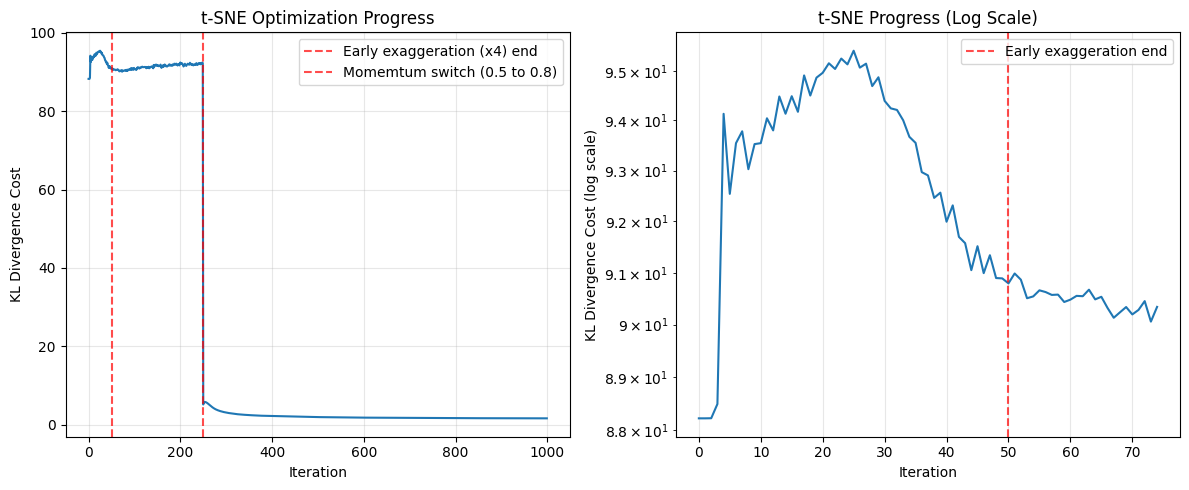

In [8]:
# Plot cost function with early exaggeration region highlighted
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(costs)
plt.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='Early exaggeration (x4) end')
plt.axvline(x=250, color='red', linestyle='--', alpha=0.7, label='Momemtum switch (0.5 to 0.8)')
plt.xlabel('Iteration')
plt.ylabel('KL Divergence Cost')
plt.title('t-SNE Optimization Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(costs[:75])
plt.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='Early exaggeration end')
plt.xlabel('Iteration')
plt.ylabel('KL Divergence Cost (log scale)')
plt.yscale('log')
plt.title('t-SNE Progress (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()